Author: Ryan Timbrook (RTIMBROO)  
DATE: 12/3/2019 <br>
Topic: 

## 1. Objective:
-----------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import json
import os
from os import path
import fnmatch
import io
import re
import string
from datetime import date
from datetime import time
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
%set_env 'CATALYST_LOG_LEVEL'=15

env: 'CATALYST_LOG_LEVEL'=15


In [3]:
# custome python packages
import rtimbroo_utils as br  

In [4]:
# set global properties
notebook_file_name = 'classify_train_nfl_master'
report_file_name = 'classify_train_nfl_master'
app_name = 'classify_train_nfl_master'
log_level = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# setup working directory structure
# set global properties
dataDir = './data'
logOutDir = './logs'
imageDir = './images'
outputDir = './output'

# create base output directories if they don't exist
if not os.path.exists(logOutDir): os.mkdir(logOutDir)
if not os.path.exists(imageDir): os.mkdir(imageDir)
if not os.path.exists(dataDir): os.mkdir(dataDir)
if not os.path.exists(outputDir): os.mkdir(outputDir)

In [5]:
# get a logger for troubleshooting / data exploration
logger = br.getFileLogger(logOutDir+'/',app_name,level=log_level)

In [6]:
#train_nfl_master = pd.read_csv(f'{dataDir}/train_nfl_master.csv', encoding='latin')

# the nfl_master2_df is a copy of the nfl_tweets_master.csv created from the 'merge_datasets_to_master' notebook
# it's attributes have been reduced to just the 'id' and 'text' fields for classification
#train_nfl_master = pd.read_csv(f'{dataDir}/train/nfl_master2_df.csv', encoding='latin')

train_nfl_master = pd.read_csv(f'{dataDir}/nfl_tweets_master.csv', encoding='latin')

# nfl foster list to use for custom stop word removal
nfl_roster = pd.read_csv(f'{dataDir}/nfl_teams_roster_data.csv', encoding='utf8')
nfl_coaches_df = pd.read_csv(f'{dataDir}/nfl_coaches_list.csv', encoding='utf8')

In [7]:
logger.info(f'{train_nfl_master.shape}')
train_nfl_master.head()

(10148, 13)


,id,created_at,date,time,user,text,favorite_count,year,month,day_of_month,day_of_week,nfl_type,nfl_schedule_wk
0,1200925257407827968,Sat Nov 30 23:51:08 +0000 2019,2019-11-30,23:51:08,JT_Evans97,You mean the same fan experts who could see La...,28503.0,2019,11,30,5,player,13
1,1200924548700495872,Sat Nov 30 23:48:19 +0000 2019,2019-11-30,23:48:19,MigiziLaFern,Deshaun Watson or Sam Darnold? WhoShouldIStart,161.0,2019,11,30,5,player,13
2,1200922963375280129,Sat Nov 30 23:42:01 +0000 2019,2019-11-30,23:42:01,TifdanyBrooks,RT Top 5 current NFL quarterbacks 1. Tom Bra...,10198.0,2019,11,30,5,player,13
3,1200922228168237057,Sat Nov 30 23:39:05 +0000 2019,2019-11-30,23:39:05,Schlarb23,A NFL team I love: Browns A NFL team I like: P...,1376.0,2019,11,30,5,player,13
4,1200922016636948481,Sat Nov 30 23:38:15 +0000 2019,2019-11-30,23:38:15,JoeZo88,Deshaun Watson,85828.0,2019,11,30,5,player,13


# 1. Perform Sentiment Intensity Analysis
----------------------------------------------------------------------------------------------
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

VADER Sentiment Analysis. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.

## Functions

In [8]:
def classify_vader_score_threshold(compound_score):
    pos_sent = 'positive'
    neu_sent = 'neutral'
    neg_sent = 'negative'
    sentiment_class = ''
    
    if compound_score >= 0.05:
        sentiment_class = pos_sent;
    elif compound_score > -0.05 and compound_score < 0.05:
        sentiment_class = neu_sent;
    elif compound_score <= -0.05:
        sentiment_class = neg_sent;
    else:
        logger.warning(f'classify_vader_score_threshold: compound score not in range: {compound_score}')
    return sentiment_class

In [9]:
def format_nfl_stop_words(roster, coaches):
    
    # NFL Teams Stop Words
    nfl_teams = [t.replace('_', ' ') for t in roster['team']]
    #logger.info(f'{nfl_teams}')
    
    # NFL Players Stop Words
    nfl_teams_players = [re.sub(r'\'|"|-|\.','',p.lower()) for p in roster['roster']]

    nfl_players = []
    for i, team_list in enumerate(nfl_teams_players):
        team_players = team_list.split(',')
        for player in team_players:
            nfl_players.append(re.sub(r'\[|\]','',player.strip()))
        #if i == 2: break
        
    # NFL Coaches Stop Words
    nfl_coaches = coaches['Coach']
    nfl_coaches = [re.sub(r'\*|\'','',c.lower()) for c in nfl_coaches]
    
    # dump stop words to file to be used by other modules
    with open(f'{dataDir}/nfl_stop_words_config.txt', 'w+') as f:
    
        nfl_stop_words = {'coaches':nfl_coaches,'players':nfl_players,'teams':nfl_teams}
        json.dump(nfl_stop_words,f)
        
    nfl_types_stop_words = []

    for coach in nfl_coaches:
        nfl_types_stop_words.append(coach)

    for player in nfl_players:
        nfl_types_stop_words.append(player)

    for team in nfl_teams:
        nfl_types_stop_words.append(team)
    #logger.info(f'team count: {i+1} | player count: {len(nfl_players)} | \n{nfl_players}')
    nfl_types_stop_words_v2 = [name for names in nfl_types_stop_words for name in names.split()]
    
    return nfl_types_stop_words_v2
    
    

In [10]:
nfl_stop_words = format_nfl_stop_words(nfl_roster,nfl_coaches_df)
logger.debug(f'nfl_stop_words:\n{nfl_stop_words}')


Vader Sentiment Analysis Resources:
* [Using VADER to handle sentiment analysis with social media text](http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html)
* [Github - cjhutto](https://github.com/cjhutto/vaderSentiment)

In [11]:
# train on tweet text specific to type
coach_train_nfl_master = train_nfl_master[train_nfl_master['nfl_type'] == 'coach']
player_train_nfl_master = train_nfl_master[train_nfl_master['nfl_type'] == 'player']
team_train_nfl_master = train_nfl_master[train_nfl_master['nfl_type'] == 'team']

## 1.1 Sentiment Classification - Uncleansed Tweet Text

In [12]:
def classify_tweet_sentiment(df, nfltype,clean=False):
    
    analyzer = SentimentIntensityAnalyzer()
    pol_scores=[]
    pol_text=[]
    pol_text_id=[]
    pol_text_clean = []

    # ---- Execute Sentiment Analyzer ---- #
    with io.open(f'{outputDir}/vader_tweet_sentiment.txt','w+',encoding='latin') as f:
        for index, row in df.iterrows():
            try:
                if clean:
                    vs = analyzer.polarity_scores(str(row['text_clean']))
                    pol_text_clean.append(str(row['text_clean']))
                else:
                    vs = analyzer.polarity_scores(str(row['text']))
                
                pol_scores.append(vs)
                pol_text.append(row['text'])
                pol_text_id.append(row['id'])
                try:
                    if clean:
                        f.write("{:-<65} {}".format(row['text_clean'], str(vs))+'\n')
                    else: 
                        f.write("{:-<65} {}".format(row['text'], str(vs))+'\n')
                    #logger.debug("{:-<65} {}".format(row['text'], str(vs)))
                except BaseException as be:
                    logger.warning(f'***WARNING***: SentimentIntensityAnalyzer --- Caught Exception: {be}')
            except BaseException as be:
                logger.warning(f'***WARNING***: SentimentIntensityAnalyzer --- Caught Exception: {be}')
    
    
    # ---- Evaluate the polarity scoring -----#
    labeled_train_nfl_df = pd.DataFrame()
    labeled_train_nfl_df['id'] = pol_text_id
    labeled_train_nfl_df['text'] = pol_text
    if clean: labeled_train_nfl_df['text_clean'] = pol_text_clean
    labeled_train_nfl_df['scores'] = pol_scores

    logger.info(f'labeled_train_nfl_df.shape: {labeled_train_nfl_df.shape}')
    labeled_train_nfl_df.head()
    
    # ---- Evaluate the polarity scoring
    pol_scores_df = pd.DataFrame(pol_scores)
    logger.info(pol_scores_df.describe())
    #pol_scores_df.head()

    # ---- classify each sentence as 'positive', 'negative' or 'neutral' - see function above
    sentiment_classes = [classify_vader_score_threshold(c) for c in pol_scores_df['compound'] ]
    labeled_train_nfl_df['sentiment'] = sentiment_classes
    labeled_train_nfl_df.head()
    
    # ---- Visualize Classification Results ---- #
    ## -- Scatter Plot -- ##
    sc_plot = sns.scatterplot(x='neg',y='pos',hue='compound', data=pol_scores_df)
    sc_plot.axes.set_title(f'{nfltype.upper()} Plolarity Scoring')
    plt.show()
    
    ## -- Count Plot -- ##
    scount = sns.countplot(x='sentiment', data=labeled_train_nfl_df)
    scount.axes.set_title(f'{nfltype.upper()} Plolarity Scoring')
    plt.show()
    logger.info(f'Negative Count: {len(labeled_train_nfl_df[labeled_train_nfl_df["sentiment"] == "negative"])}')
    logger.info(f'Positive Count: {len(labeled_train_nfl_df[labeled_train_nfl_df["sentiment"] == "positive"])}')
    logger.info(f'Neutral Count: {len(labeled_train_nfl_df[labeled_train_nfl_df["sentiment"] == "neutral"])}')

    neg_count = len(labeled_train_nfl_df[labeled_train_nfl_df["sentiment"] == "negative"])
    pos_count = len(labeled_train_nfl_df[labeled_train_nfl_df["sentiment"] == "positive"])

    logger.info(neg_count/pos_count)
    logger.info (pos_count/neg_count)
    
    ## -- Violine Distribution Plots -- ## 
    # -- Polarity Score - Compound -- #
    fig, ax = plt.subplots()
    ax.violinplot(pol_scores_df['compound'], vert=False)
    plt.show()
                
    # -- Polarity Score - Positive -- #
    fig, ax = plt.subplots()
    ax.violinplot(pol_scores_df['pos'], vert=False)          
    plt.show()
                
    # -- Polarity Score - Negative -- #
    fig, ax = plt.subplots()
    ax.violinplot(pol_scores_df['neg'], vert=False)
    plt.show()
                
    return labeled_train_nfl_df
    

labeled_train_nfl_df.shape: (289, 3)
         compound         neg         neu         pos
count  289.000000  289.000000  289.000000  289.000000
mean     0.075675    0.036439    0.906170    0.057370
std      0.272975    0.090865    0.125383    0.083709
min     -0.700300    0.000000    0.370000    0.000000
25%      0.000000    0.000000    0.833000    0.000000
50%      0.000000    0.000000    0.957000    0.000000
75%      0.226300    0.000000    1.000000    0.103000
max      0.726900    0.630000    1.000000    0.433000


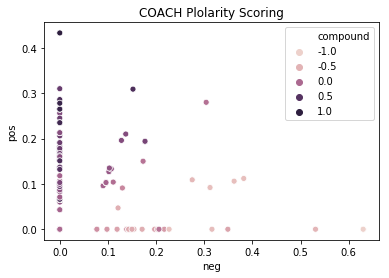

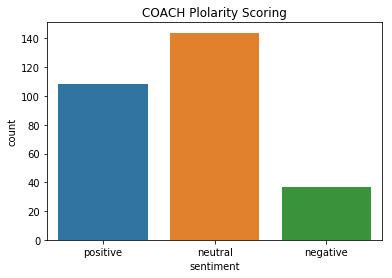

Negative Count: 37
Positive Count: 108
Neutral Count: 144
0.3425925925925926
2.918918918918919


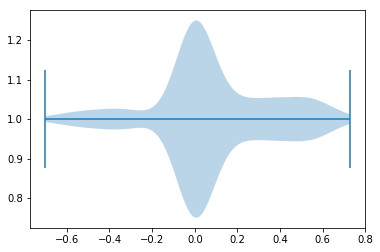

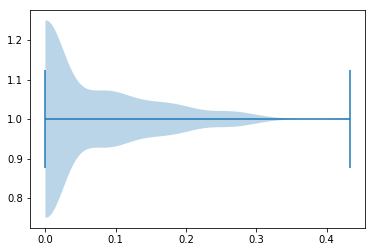

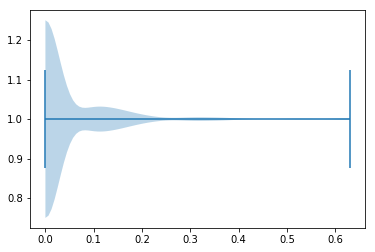

In [13]:
coach_labeled_train_nfl_df = classify_tweet_sentiment(coach_train_nfl_master,'coach')

labeled_train_nfl_df.shape: (4926, 3)
          compound          neg          neu          pos
count  4926.000000  4926.000000  4926.000000  4926.000000
mean      0.138168     0.042314     0.857738     0.099740
std       0.442292     0.080917     0.147637     0.138563
min      -0.906200     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.748000     0.000000
50%       0.000000     0.000000     0.877000     0.000000
75%       0.476700     0.063750     1.000000     0.171000
max       0.971600     0.554000     1.000000     1.000000


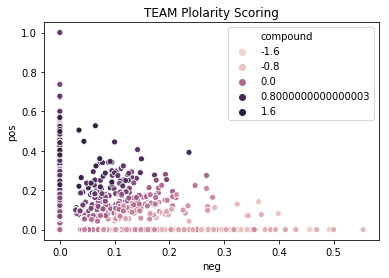

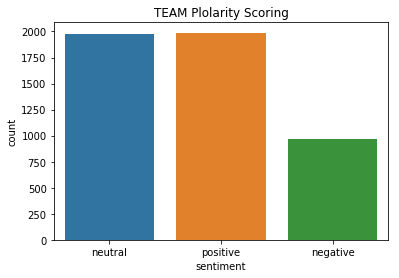

Negative Count: 963
Positive Count: 1988
Neutral Count: 1975
0.4844064386317907
2.064382139148494


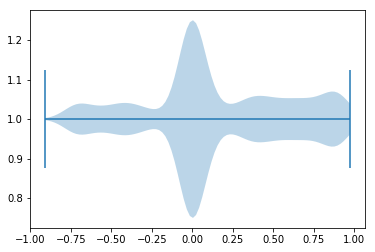

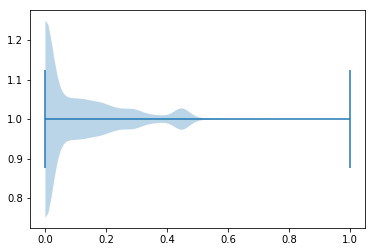

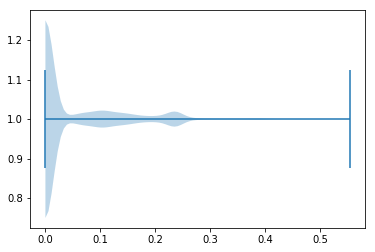

In [14]:
team_labeled_train_nfl_df = classify_tweet_sentiment(team_train_nfl_master,'team')

labeled_train_nfl_df.shape: (4933, 3)
          compound          neg          neu          pos
count  4933.000000  4933.000000  4933.000000  4933.000000
mean      0.120119     0.040137     0.867089     0.092780
std       0.389532     0.081245     0.151367     0.126988
min      -0.933700     0.000000     0.263000     0.000000
25%       0.000000     0.000000     0.773000     0.000000
50%       0.000000     0.000000     0.927000     0.000000
75%       0.340000     0.055000     1.000000     0.143000
max       0.960700     0.669000     1.000000     0.737000


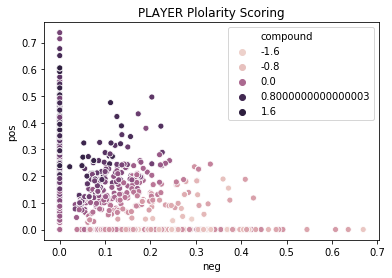

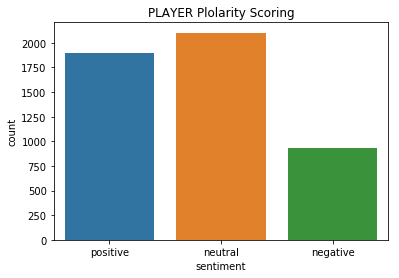

Negative Count: 935
Positive Count: 1895
Neutral Count: 2103
0.49340369393139843
2.0267379679144386


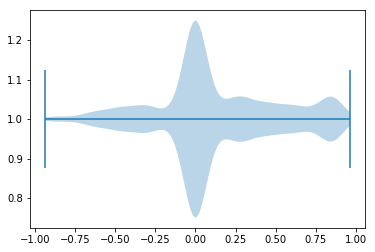

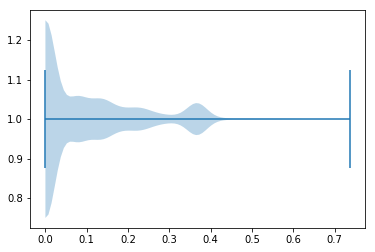

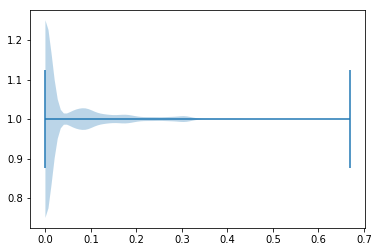

In [15]:
player_labeled_train_nfl_df = classify_tweet_sentiment(player_train_nfl_master,'player')

In [16]:
labeled_train_nfl_df = pd.DataFrame()

labeled_train_nfl_df = labeled_train_nfl_df.append(coach_labeled_train_nfl_df, ignore_index=True)
labeled_train_nfl_df = labeled_train_nfl_df.append(player_labeled_train_nfl_df, ignore_index=True)
labeled_train_nfl_df = labeled_train_nfl_df.append(team_labeled_train_nfl_df, ignore_index=True)

## 1.2 Sentiment Classification - Cleansed Tweet Text

In [17]:
custom_stop_words=['RT','rt','deshaun', 'watson','bill', 'obrian','houston', 'texans','nfl']
custom_stop_words = custom_stop_words + nfl_stop_words
logger.info(f'stop word list length: {len(custom_stop_words)}')

stop word list length: 5495


In [18]:
# create new data frame to hold cleaned text
train_nfl_master_clean_df = pd.DataFrame()
train_nfl_master_clean_df['id'] = train_nfl_master['id']
train_nfl_master_clean_df['text'] = train_nfl_master['text']
train_nfl_master_clean_df['nfl_type'] = train_nfl_master['nfl_type']
train_nfl_master_clean_df['text_clean'] = [br.clean_text(logger, str(t), custom_stop_words) for t in train_nfl_master['text']]

In [19]:
train_nfl_master_clean_df.head()

,id,text,nfl_type,text_clean
0,1200925257407827968,You mean the same fan experts who could see La...,player,mean fan experts could see would great
1,1200924548700495872,Deshaun Watson or Sam Darnold? WhoShouldIStart,player,whoshouldistart
2,1200922963375280129,RT Top 5 current NFL quarterbacks 1. Tom Bra...,player,top current quarterbacks russel watsonâ¦
3,1200922228168237057,A NFL team I love: Browns A NFL team I like: P...,player,team team like team dislike team hate nflâ¦
4,1200922016636948481,Deshaun Watson,player,


In [20]:
# train on tweet text specific to type
coach_train_nfl_master_clean = train_nfl_master_clean_df[train_nfl_master_clean_df['nfl_type'] == 'coach']
player_train_nfl_master_clean = train_nfl_master_clean_df[train_nfl_master_clean_df['nfl_type'] == 'player']
team_train_nfl_master_clean = train_nfl_master_clean_df[train_nfl_master_clean_df['nfl_type'] == 'team']

labeled_train_nfl_df.shape: (289, 4)
         compound         neg         neu         pos
count  289.000000  289.000000  289.000000  289.000000
mean     0.078599    0.058149    0.807661    0.134145
std      0.258318    0.153705    0.233070    0.189969
min     -0.700300    0.000000    0.226000    0.000000
25%      0.000000    0.000000    0.597000    0.000000
50%      0.000000    0.000000    1.000000    0.000000
75%      0.250000    0.000000    1.000000    0.242000
max      0.670500    0.773000    1.000000    0.730000


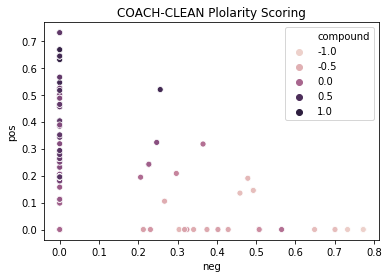

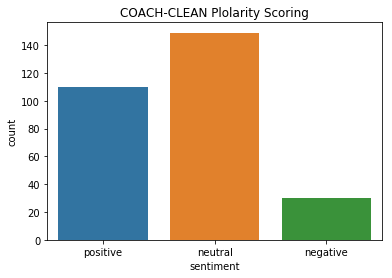

Negative Count: 30
Positive Count: 110
Neutral Count: 149
0.2727272727272727
3.6666666666666665


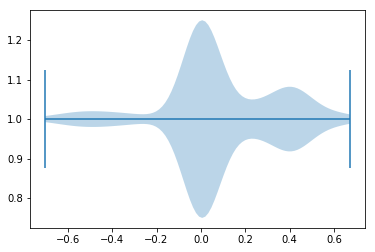

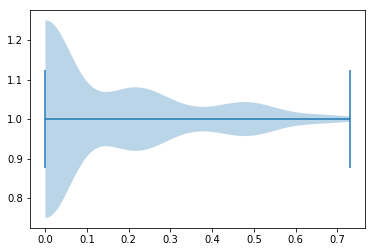

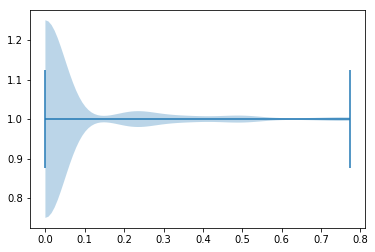

In [21]:
coach_labeled_train_nfl_clean_df = classify_tweet_sentiment(coach_train_nfl_master_clean,'coach-clean',clean=True)

labeled_train_nfl_df.shape: (4933, 4)
          compound          neg          neu          pos
count  4933.000000  4933.000000  4933.000000  4933.000000
mean      0.127472     0.073410     0.727908     0.174595
std       0.368414     0.157516     0.283596     0.229330
min      -0.933700     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.494000     0.000000
50%       0.000000     0.000000     0.762000     0.000000
75%       0.361200     0.000000     1.000000     0.294000
max       0.960700     1.000000     1.000000     1.000000


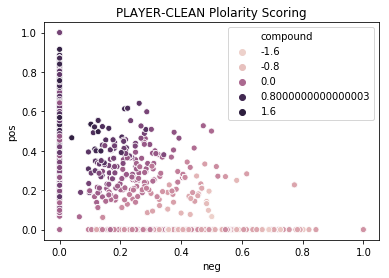

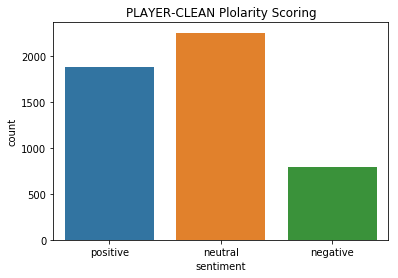

Negative Count: 795
Positive Count: 1882
Neutral Count: 2256
0.422422954303932
2.3672955974842766


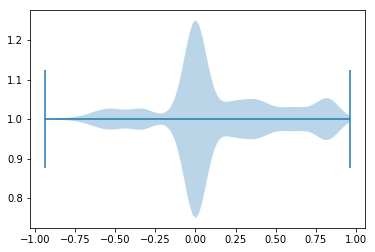

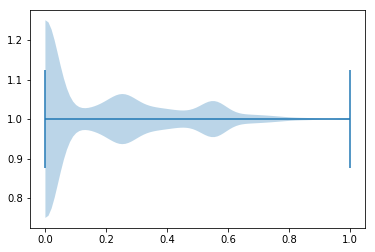

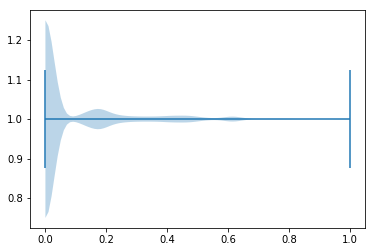

In [22]:
player_labeled_train_nfl_clean_df = classify_tweet_sentiment(player_train_nfl_master_clean,'player-clean',clean=True)

labeled_train_nfl_df.shape: (4926, 4)
          compound          neg          neu          pos
count  4926.000000  4926.000000  4926.000000  4926.000000
mean      0.104926     0.073991     0.763931     0.152541
std       0.399971     0.145755     0.236137     0.201643
min      -0.891000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.574000     0.000000
50%       0.000000     0.000000     0.775000     0.000000
75%       0.401900     0.064000     1.000000     0.294000
max       0.964300     1.000000     1.000000     1.000000


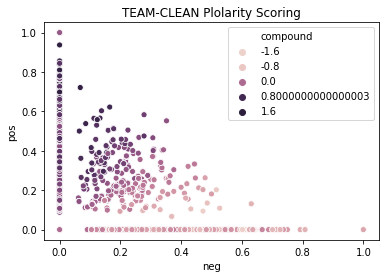

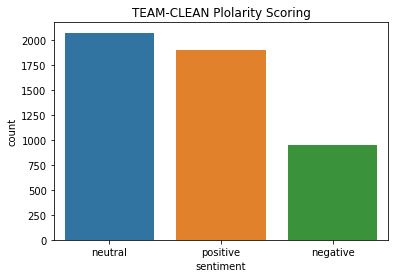

Negative Count: 951
Positive Count: 1900
Neutral Count: 2075
0.5005263157894737
1.9978969505783386


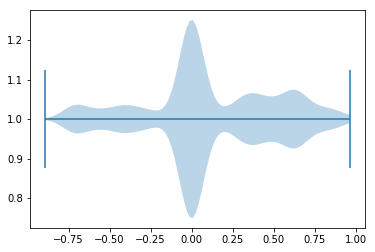

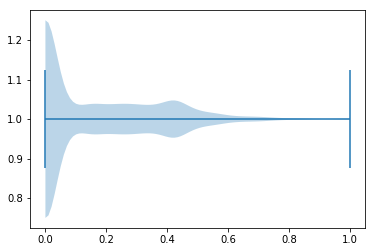

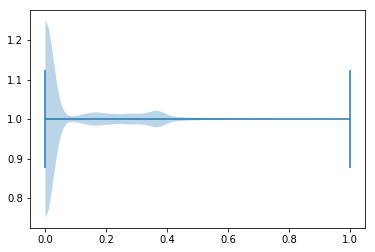

In [23]:
team_labeled_train_nfl_clean_df = classify_tweet_sentiment(team_train_nfl_master_clean,'team-clean',clean=True)

In [24]:
labeled_train_nfl_clean_df = pd.DataFrame()

labeled_train_nfl_clean_df = labeled_train_nfl_clean_df.append(coach_labeled_train_nfl_clean_df, ignore_index=True)
labeled_train_nfl_clean_df = labeled_train_nfl_clean_df.append(player_labeled_train_nfl_clean_df, ignore_index=True)
labeled_train_nfl_clean_df = labeled_train_nfl_clean_df.append(team_labeled_train_nfl_clean_df, ignore_index=True)

labeled_train_nfl_clean_df.head()

,id,text,text_clean,scores,sentiment
0,1200324875115810816,Bill O'Brien is the most successful ex-Bill Be...,successful exbill assistant get want,"{'neg': 0.0, 'neu': 0.37, 'pos': 0.63, 'compou...",positive
1,1200086820928622592,"As always, Patriots stand in the way for Bill ...",always stand espn,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
2,1200023580542676993,"As always, Patriots stand in the way for Bill ...",always stand blog trending monkey viraâ¦,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
3,1199968219286687745,"As always, Patriots stand in the way for Bill ...",always stand football,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
4,1199961952556109824,"As always, Patriots stand in the way for Bill ...",always stand,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral


## Merge trained tweet data frames together

## Write New Training Data Set to File

In [28]:
labeled_train_nfl_df.to_csv(f'{dataDir}/sentiment_labeled_train_nfl.csv', index=False)
labeled_train_nfl_clean_df.to_csv(f'{dataDir}/sentiment_labeled_train_nfl_clean.csv', index=False)

NameError: name 'labeled_train_nfl_df' is not defined

In [26]:
t = pd.read_csv(f'{dataDir}/sentiment_labeled_train_nfl_clean.csv')
t.head()

,id,text,text_clean,scores,sentiment
0,1200324875115810816,Bill O'Brien is the most successful ex-Bill Be...,successful exbill assistant get want,"{'neg': 0.0, 'neu': 0.37, 'pos': 0.63, 'compou...",positive
1,1200086820928622592,"As always, Patriots stand in the way for Bill ...",always stand espn,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
2,1200023580542676993,"As always, Patriots stand in the way for Bill ...",always stand blog trending monkey viraâ¦,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
3,1199968219286687745,"As always, Patriots stand in the way for Bill ...",always stand football,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
4,1199961952556109824,"As always, Patriots stand in the way for Bill ...",always stand,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral


In [27]:
del labeled_train_nfl_clean_df
del labeled_train_nfl_df
del team_labeled_train_nfl_df
del player_labeled_train_nfl_df
del coach_labeled_train_nfl_df
del team_labeled_train_nfl_clean_df
del player_labeled_train_nfl_clean_df
del coach_labeled_train_nfl_clean_df
del train_nfl_master